# Crop Type Classification - ML model building and optimisation

This notebook demonstrates how to build and tune machine learning models to classify crop types on NDVI timeseries and bhuvan fasal GT. Along with using all 14 NDVI features, we are also evaluating the minimum number of features required for classification so that we are able to generate crop map reports earlier. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda create --name 'env_name' --file requirements.txt
$ conda activate 'env_name'
```

### Key Libraries:

- [XGBoost](https://xgboost.readthedocs.io/en/stable/): ML model for crop type classification.
- [Geopandas](https://geopandas.org/en/stable/docs.html), [Pandas]((https://xgboost.readthedocs.io/en/stable/)): Data handling and manipulation.
- [Matplotlib](https://matplotlib.org/stable/index.html), [Seaborn](https://seaborn.pydata.org/tutorial.html): Utilized for data visualization.
- [Scikit-learn](https://scikit-learn.org/stable/user_guide.html): For scaling data, obtaining relevant metrics etc.

### Modelling details:
- Model Type: XGBoost
- ML Task: Multiclass classification
- Crop Types (Target): mustard, wheat and potato
- Target Metric: harmonic mean of precision w.r.t each crop class. Formula: 3/(1/PrMustard + 1/PrWheat + 1/PrPotato) (Note: Pr is Precision)

--------

# Module and data imports

In [1]:
# Changing working dir to the repository main folder
import os
try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-2]))
    kernel_is_loaded = True

import numpy as np
import pandas as pd
import random
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 20

# Seeding
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

In [2]:
# Importing train, validation and test sets. 

train = pd.read_csv('notebooks/demo/data_files/train.csv')
val = pd.read_csv('notebooks/demo/data_files/val.csv')
test = pd.read_csv('notebooks/demo/data_files/test.csv')

# Predictor and label split

In [3]:
X_train = train.drop('crop_type', axis=1)
y_train = train['crop_type']

X_val = val.drop('crop_type', axis=1)
y_val = val['crop_type']

X_test = test.drop('crop_type', axis=1)
y_test = test['crop_type']

# Modelling

In [6]:
# Model Training and Tuning
# This also includes building models which can generate early crop map reports

fort_nights = list(X_train.loc[:, 'oct_1f':'apr_2f'].columns)

params = {'n_estimators':np.arange(5,50,5), 'learning_rate':np.arange(0.05, 0.55, 0.1), 
          'max_depth':np.arange(1,5,1)}

param_grid = list(ParameterGrid(params))
max_precision_scores = []
best_params = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    precision_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1,2])
        precision_scores.append(precision)
        
    precision_scores = pd.DataFrame(precision_scores)
    hms = precision_scores.apply(lambda row : len(row) / np.sum(1.0 / row), axis=1).values
    best_hm = np.max(hms)
    best_hm_idx = np.argmax(hms)
    best_params.append(param_grid[best_hm_idx])
    max_precision_scores.append(best_hm)    
    fns_used.append('-'.join(map(str, temp_X_train.columns[[0,-1]])))
    print(f'---> Validation on {len(fort_nights) - i} fns done! Best harmonic mean of precision on validation data is {best_hm}')
    
    i += 1
    
print('Done!!')

---> Validation on 14 fns done! Best harmonic mean of precision on validation data is 0.9630411826821542
---> Validation on 13 fns done! Best harmonic mean of precision on validation data is 0.9807692307692308
---> Validation on 12 fns done! Best harmonic mean of precision on validation data is 0.95
---> Validation on 11 fns done! Best harmonic mean of precision on validation data is 0.9083665338645419
---> Validation on 10 fns done! Best harmonic mean of precision on validation data is 0.9241223103057759
---> Validation on 9 fns done! Best harmonic mean of precision on validation data is 0.9621380846325167
---> Validation on 8 fns done! Best harmonic mean of precision on validation data is 0.9063981042654028
---> Validation on 7 fns done! Best harmonic mean of precision on validation data is 0.9251700680272109
---> Validation on 6 fns done! Best harmonic mean of precision on validation data is 0.8690712865663164
---> Validation on 5 fns done! Best harmonic mean of precision on validat

In [7]:
# Testing the best classifiers on Unseen/Test sets. 

test_reports = []
test_precision_scores = []
confusion_matrices = []
best_models = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**best_params[i])
    
    strt_fn, end_fn = fns_used[i].split('-')
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    best_models.append(best_classifier)
    test_pred = best_classifier.predict(temp_X_test)
    report = classification_report(y_test, test_pred, target_names=['Mustard', 'Wheat','Potato'], output_dict=True)
    df = pd.DataFrame(report).transpose().loc[:'Potato',:'f1-score']
    test_reports.append(df)
    test_precision_scores.append(df['precision'].values)
    print(fns_used[i])
    display(test_reports[i])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Mustard', 1:'Wheat',2:'Potato'}).rename({0:'Mustard', 1:'Wheat',2:'Potato'}, axis=1)
    confusion_matrices.append(cf)

oct_1f-apr_2f


,precision,recall,f1-score
Mustard,0.857143,0.900000,0.878049
Wheat,1.000000,0.842105,0.914286
Potato,0.842105,0.941176,0.888889


oct_1f-apr_1f


,precision,recall,f1-score
Mustard,0.900000,0.900000,0.900000
Wheat,1.000000,0.894737,0.944444
Potato,0.842105,0.941176,0.888889


oct_1f-mar_2f


,precision,recall,f1-score
Mustard,0.888889,0.800000,0.842105
Wheat,1.000000,0.947368,0.972973
Potato,0.750000,0.882353,0.810811


oct_1f-mar_1f


,precision,recall,f1-score
Mustard,0.863636,0.950000,0.904762
Wheat,1.000000,0.894737,0.944444
Potato,0.882353,0.882353,0.882353


oct_1f-feb_2f


,precision,recall,f1-score
Mustard,0.863636,0.950000,0.904762
Wheat,1.000000,0.894737,0.944444
Potato,0.882353,0.882353,0.882353


oct_1f-feb_1f


,precision,recall,f1-score
Mustard,0.850000,0.850000,0.850000
Wheat,0.944444,0.894737,0.918919
Potato,0.777778,0.823529,0.800000


oct_1f-jan_2f


,precision,recall,f1-score
Mustard,0.888889,0.800000,0.842105
Wheat,0.900000,0.947368,0.923077
Potato,0.833333,0.882353,0.857143


oct_1f-jan_1f


,precision,recall,f1-score
Mustard,0.850000,0.850000,0.850000
Wheat,0.947368,0.947368,0.947368
Potato,0.823529,0.823529,0.823529


oct_1f-dec_2f


,precision,recall,f1-score
Mustard,0.782609,0.900000,0.837209
Wheat,0.789474,0.789474,0.789474
Potato,0.857143,0.705882,0.774194


oct_1f-dec_1f


,precision,recall,f1-score
Mustard,0.727273,0.800000,0.761905
Wheat,0.789474,0.789474,0.789474
Potato,0.800000,0.705882,0.750000


oct_1f-nov_2f


,precision,recall,f1-score
Mustard,0.800000,0.800000,0.800000
Wheat,0.833333,0.789474,0.810811
Potato,0.666667,0.705882,0.685714


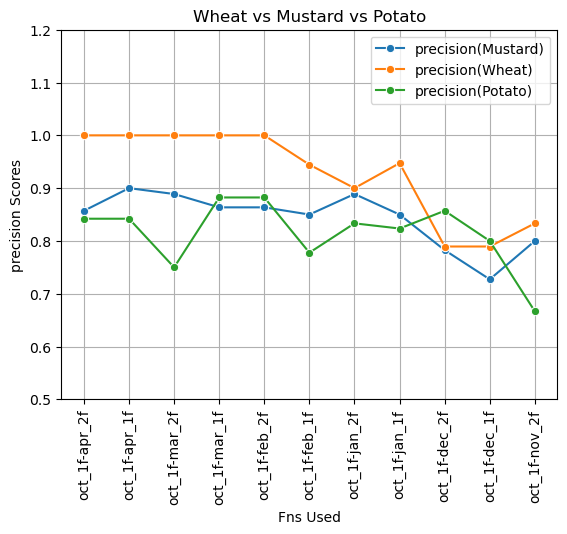

In [8]:
# Lineplots for precisions w.r.t each crop class. 

sns.lineplot(y=np.array(test_precision_scores)[:,0], x=fns_used, label='precision(Mustard)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,1], x=fns_used, label='precision(Wheat)', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,2], x=fns_used, label='precision(Potato)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('precision Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Mustard vs Potato')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

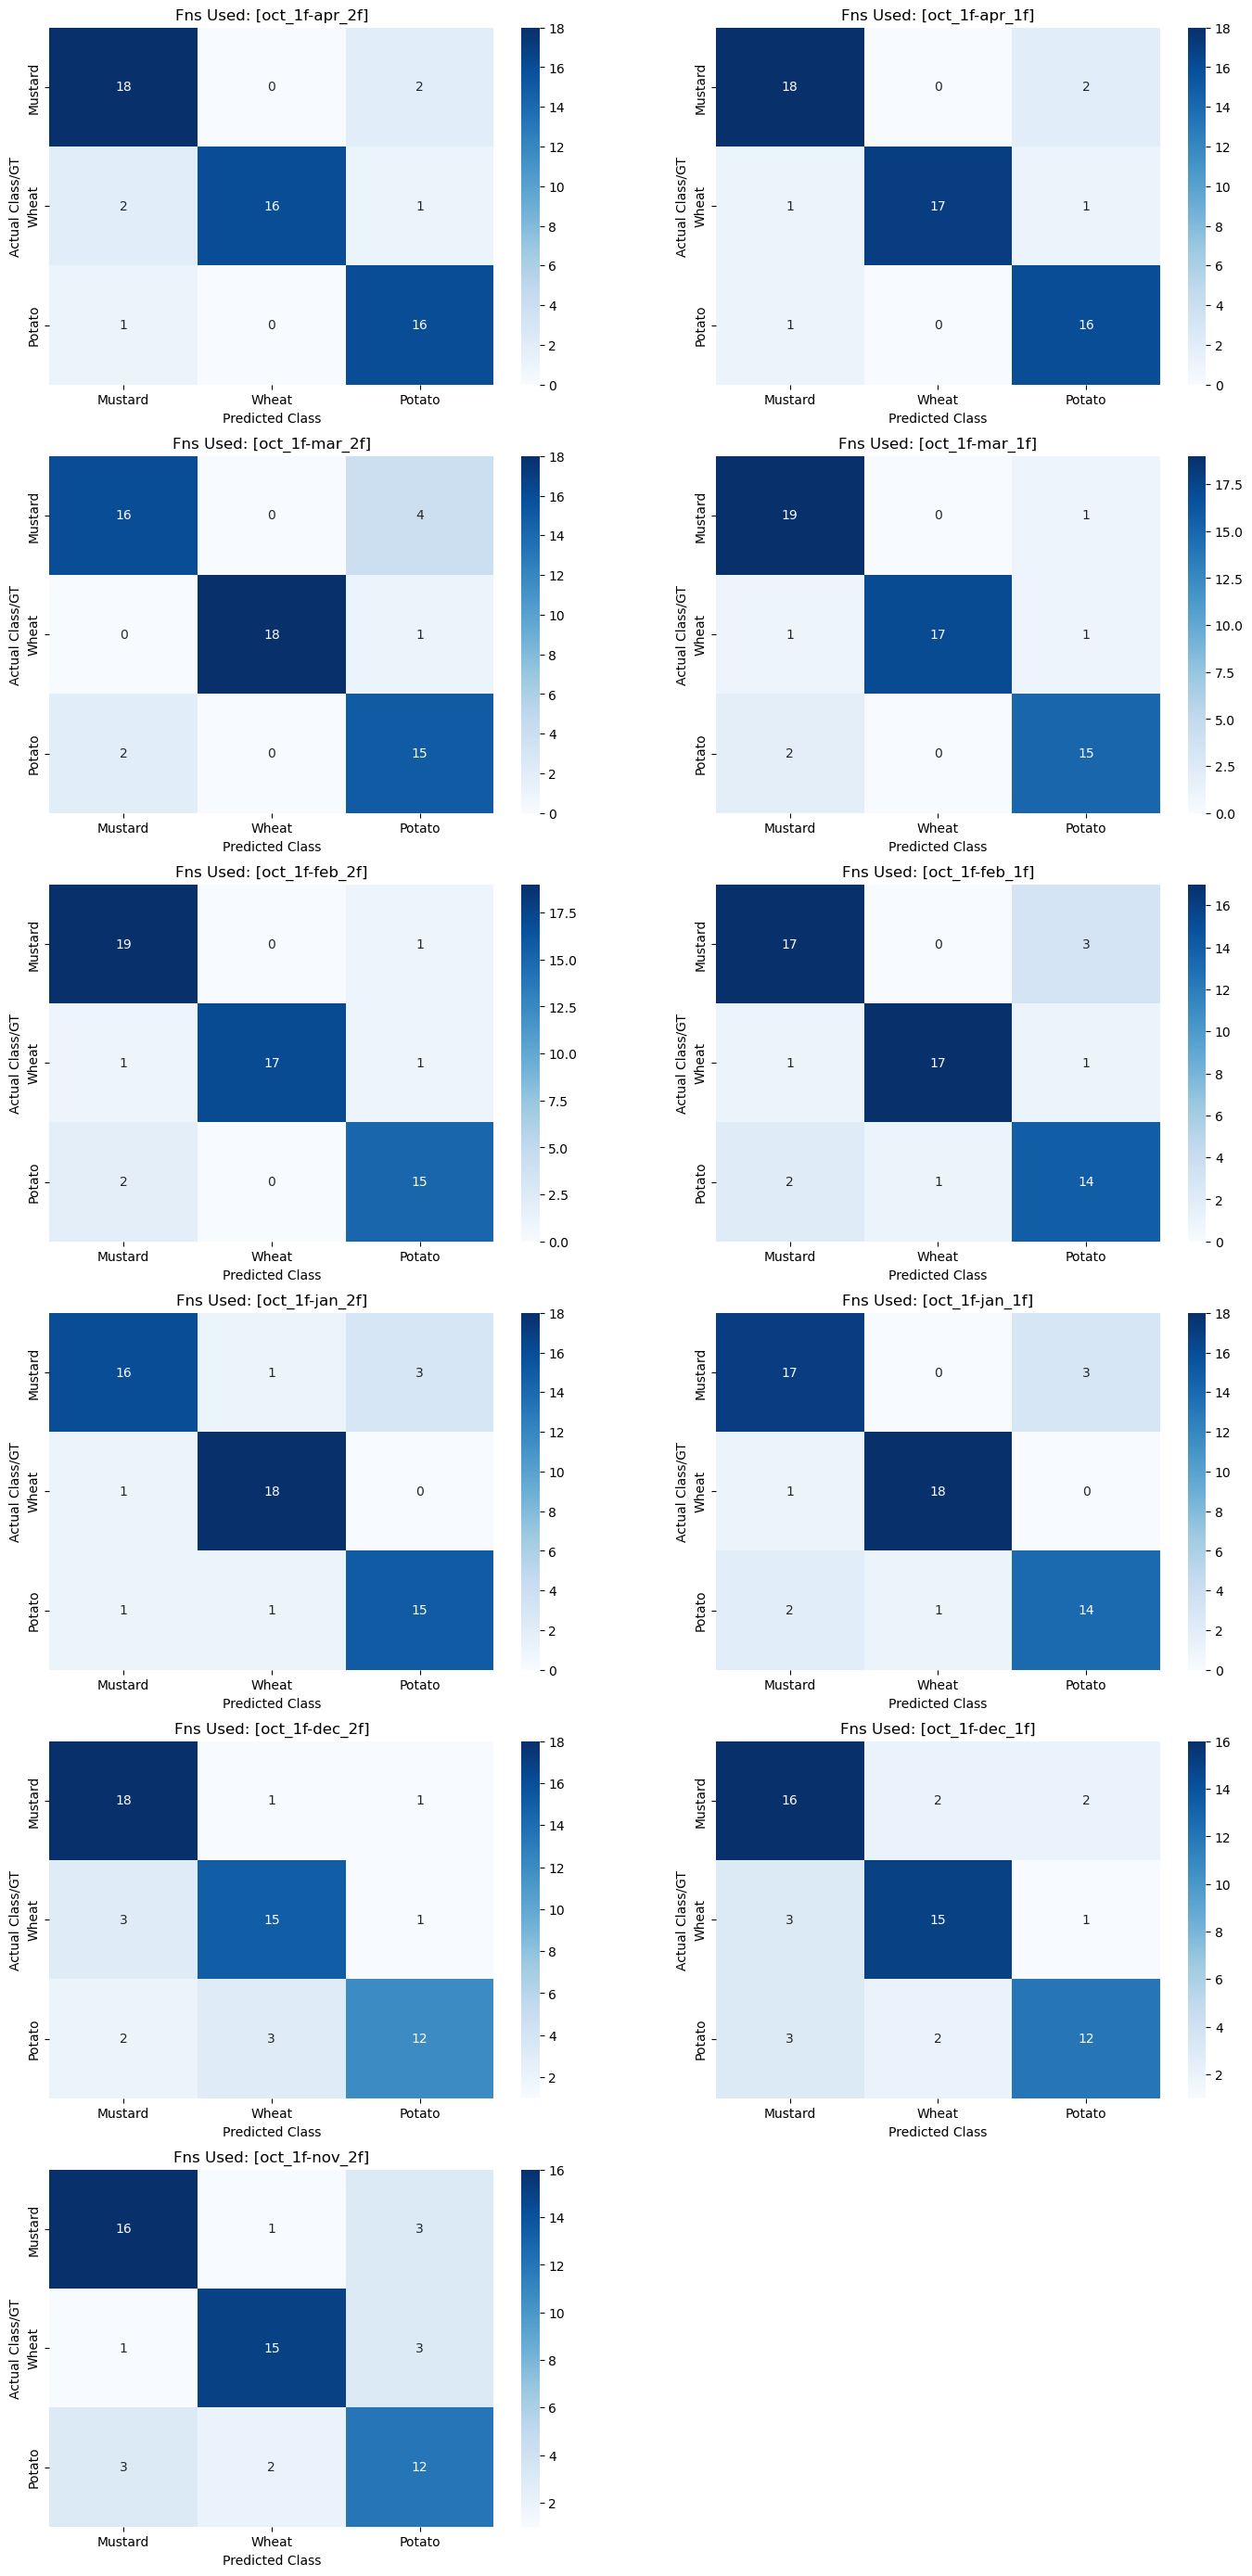

In [9]:
# Confusion matrices

plt.figure(figsize=(17,35))

for i in range(len(confusion_matrices)):
    plt.subplot(6,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()